<a href="https://colab.research.google.com/github/fukuchikeitay6-hue/myFirstProject/blob/main/complexNonlinearLeastSquares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$
\begin{align}
Z_{CPE} &= \frac{1}{Q_{CPE} (j \omega)^n} \\
&= \frac{1}{Q_{CPE}\omega^n}j^{-n} \\
&= \frac{1}{Q_{CPE}\omega^n} \left( \cos{\frac{\pi}{2}} + j\sin{\frac{\pi}{2}} \right)^{-n} \\
&= \frac{1}{Q_{CPE}\omega^n} \left( \cos{\frac{n\pi}{2}} - j\sin{\frac{n\pi}{2}} \right) \\
Re(Z_{CPE}) &= \frac{1}{Q_{CPE}\omega^n} \cos{\frac{n\pi}{2}} \\
Im(Z_{CPE}) &= -\frac{1}{Q_{CPE}\omega^n} \sin{\frac{n\pi}{2}}
\end{align}
$$


In [60]:
import math
from abc import ABC, abstractmethod
import numpy as np

class Components(ABC):
    @abstractmethod
    def impedance(self, omega:np.ndarray) -> np.ndarray:
        """
        return: impedance matrix
        [Re(Z1), Im(Z1), Re(Z2), Im(Z2), ...]
        """
        pass

    def __add__(self, other):
        return Series(self, other)

    def __mul__(self, other):
        return Parallel(self, other)

    def realImpedance(self, omega:np.ndarray) -> np.ndarray:
        return self.impedance(omega)[::2]

    def imagImpedance(self, omega:np.ndarray) -> np.ndarray:
        return self.impedance(omega)[1::2]

    def magnitude(self, omega:np.ndarray) -> np.ndarray:
        return np.sqrt(self.realImpedance(omega)**2 + self.imagImpedance(omega)**2)

    def phase(self, omega:np.ndarray, unit:str="deg") -> np.ndarray:
        if unit == "deg":
            return np.atan2(self.imagImpedance(omega), self.realImpedance(omega)) * 180 / np.pi
        elif unit == "rad":
            return np.atan2(self.imagImpedance(omega), self.realImpedance(omega))
        else:
            raise ValueError(f"nonvalid unit: {unit}")

class Resistor(Components):
    def __init__(self, R:float):
        self.R = R

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        result[::2] = self.R
        return result

class Capacitor(Components):
    def __init__(self, C:float):
        self.C = C

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        result[1::2] = -1 / (omega * self.C)
        return result

class Inductor(Components):
    def __init__(self, L:float):
        self.L = L

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        result[1::2] = (omega * self.L)
        return result

class CPE(Components):
    def __init__(self, Q:float, n:float):
        self.Q = Q
        self.n = n

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        result[::2] = 1 / (self.Q * omega**self.n) * np.cos(self.n * np.pi / 2)
        result[1::2] = -1 / (self.Q * omega**self.n) * np.sin(self.n * np.pi / 2)
        return result

class FaradayImpedance(Components):
    def __init__(self, R_ct, a_2, a_theta, tau_theta):
        self.R_ct = R_ct
        self.a_2 = a_2
        self.a_theta = a_theta
        self.tau_theta = tau_theta

    def impedance(self, omega:np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        A = 1 / self.R_ct + (self.a_2*self.a_theta) / (1 + (omega*self.tau_theta)**2)
        B = (self.a_2*self.a_theta*self.tau_theta*omega) / (1 + (omega*self.tau_theta)**2)
        result[::2] = A / (A**2 + B**2)
        result[1::2] = B / (A**2 + B**2)
        return result

class TransmissionLineModel(Components):
    def __init__(self, X:float, R_pore:float, Z:Components=Capacitor(1e-5)):
        self.X = X
        self.R_pore = R_pore
        self.Z = Z

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        Z = np.complex128(self.Z.realImpedance(omega) + 1j * self.Z.imagImpedance(omega))
        result[::2] = np.real(np.sqrt(self.R_pore*Z) * 1/np.tanh(np.sqrt(self.R_pore / Z)*self.X))
        result[1::2] = np.imag(np.sqrt(self.R_pore*Z) * 1/np.tanh(np.sqrt(self.R_pore / Z)*self.X))
        return result

class Series(Components):
    def __init__(self, *args:Components):
        self.components = args

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        for component in self.components:
            result += component.impedance(omega)
        return result

class Parallel(Components):
    def __init__(self, *args:Components):
        if len(args) > 2 or len(args) < 2:
            raise ValueError("Parallel components can only have two components")
        self.components = args

    def impedance(self, omega: np.ndarray) -> np.ndarray:
        result = np.zeros((len(omega)*2))
        imp1 = self.components[0].impedance(omega)
        imp2 = self.components[1].impedance(omega)
        real1 = imp1[::2]
        imag1 = imp1[1::2]
        real2 = imp2[::2]
        imag2 = imp2[1::2]
        A = real1 / (real1**2 + imag1**2) + real2 / (real2**2 + imag2**2)
        B = imag1 / (real1**2 + imag1**2) + imag2 / (real2**2 + imag2**2)
        result[::2] = A / (A**2 + B**2)
        result[1::2] = B / (A**2 + B**2)
        return result



def Randles_CPE(params:list):
    """
    args:
        params: [Rsol, Rct, Q, n]
    """
    if len(params) != 4:
        raise ValueError("params must be a list of length 4")
    Rsol = params[0]
    Rct = params[1]
    Q = params[2]
    n = params[3]
    if Rsol < 0 or Rct < 0:
        raise ValueError("Rsol and Rct must be positive")
    if n < -1 or 1 < n:
        raise ValueError("CPE n must be between -1 and 1")
    return Resistor(Rsol) + Resistor(Rct) * CPE(Q, n)

def toImpedanceMatrix(Z_Re:np.ndarray, Z_Im:np.ndarray) -> np.ndarray:
    result = np.zeros((len(Z_Re)*2))
    result[::2] = Z_Re
    result[1::2] = Z_Im
    return result

In [119]:
import matplotlib.pyplot as plt

def nyquistPlot(circuit:list[Components], omega:np.ndarray, label:list[str]|None=None, range:tuple[float, float]|None = None):
    if label is None:
        label = [""] * len(circuit)
    fig, ax = plt.subplots()
    ax.tick_params(direction="in")
    ax.set_xlabel("Re(Z) / Ohm")
    ax.set_ylabel("–Im(Z) / Ohm")
    ax.set_aspect("equal")
    for i, c in enumerate(circuit):
        ax.plot(c.realImpedance(omega), -c.imagImpedance(omega), "-o", markersize=3, label=label[i])
    if range:
        ax.set_xlim(range[0], range[1])
        ax.set_ylim(range[0], range[1])
    ax.legend()
    return fig, ax

def bodePlot(circuit:list[Components], omega:np.ndarray, label:list[str]|None=None, x_range:tuple[float, float]|None = None, y_range_magnitude:tuple[float, float]|None=None, y_range_phase:tuple[float, float]|None=None):
    if label is None:
        label = [""] * len(circuit)
    f = omega / (2*np.pi)
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].tick_params(direction="in")
    ax[1].tick_params(direction="in")
    ax[0].set_ylabel("|Z| / Ohm")
    ax[1].set_ylabel("Phase / rad")
    ax[1].set_xlabel("f / Hz")
    for i, c in enumerate(circuit):
        ax[0].plot(f, c.magnitude(omega), "-o", markersize=2, label=label[i])
        ax[1].plot(f, c.phase(omega), "-o", markersize=2)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    if x_range:
        ax.set_xlim(x_range[0], x_range[1])
    if y_range_magnitude:
        ax[0].set_ylim(y_range_magnitude[0], y_range_magnitude[1])
    if y_range_phase:
        ax[1].set_ylim(y_range_phase[0], y_range_phase[1])
    ax[0].legend()
    return fig, ax

In [121]:
f = np.logspace(-3, 6, 100, True, 10)
omega = 2*np.pi*f

c1 = Resistor(100) + TransmissionLineModel(1, 1000, Capacitor(1e-3)) + Capacitor(1e-7)
c2 = TransmissionLineModel(2, 1000, Capacitor(1e-3))
c3 = TransmissionLineModel(3, 1000, Capacitor(1e-3))

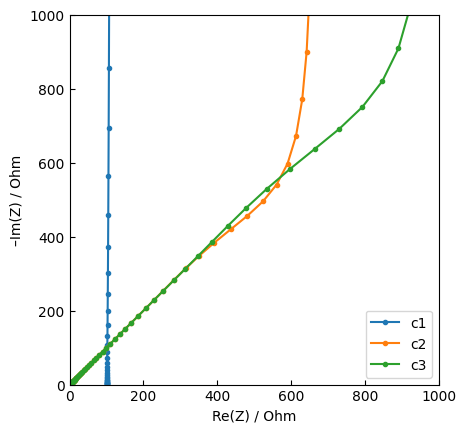

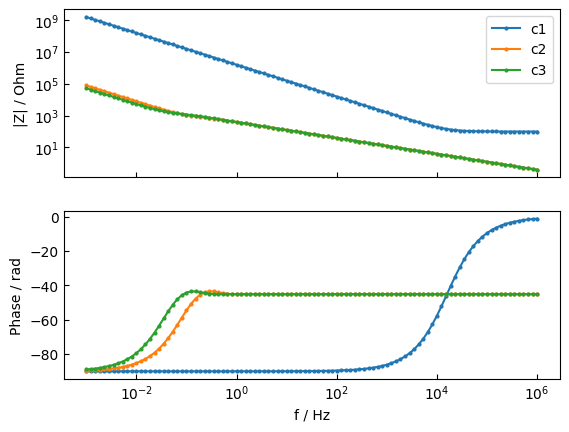

In [122]:
nyquistPlot([c1, c2, c3], omega, range=(0, 1000), label=["c1", "c2", "c3"])
bodePlot([c1, c2, c3], omega, label=["c1", "c2", "c3"])

plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame({"Z_Re": c2.realImpedance(omega), "Z_Im": -c2.imagImpedance(omega)})
df.to_csv("data.txt", index=False)

# 最小二乗法

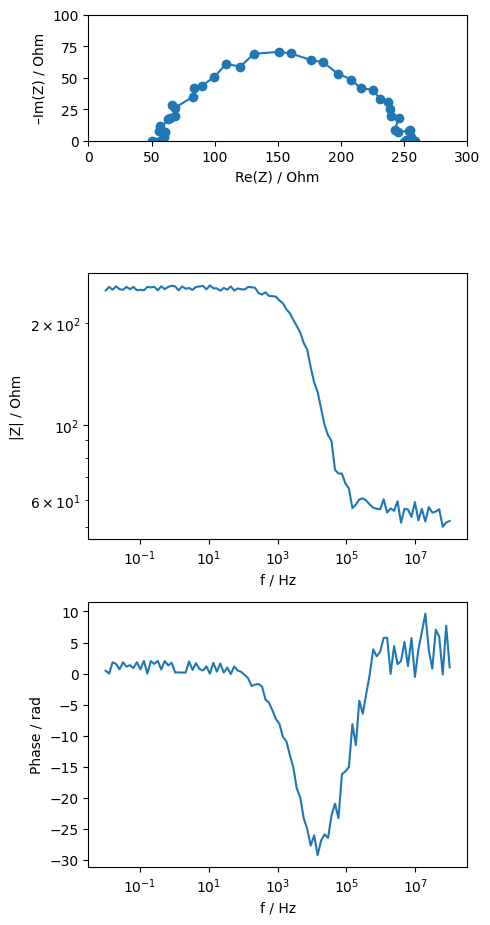

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

frequency = np.logspace(-2, 8, 100, True, 10)
omega = 2 * np.pi * frequency
fig = plt.figure(figsize=(5, 10))
nyquist = fig.add_subplot(3, 1, 1)
bode_mag = fig.add_subplot(3, 1, 2)
bode_phase = fig.add_subplot(3, 1, 3)
nyquist.set_xlabel("Re(Z) / Ohm")
nyquist.set_ylabel("–Im(Z) / Ohm")
nyquist.set_aspect("equal")
nyquist.set_xlim(0, 300)
nyquist.set_ylim(0, 100)
bode_mag.set_xscale("log")
bode_mag.set_yscale("log")
bode_mag.set_xlabel("f / Hz")
bode_mag.set_ylabel("|Z| / Ohm")
bode_phase.set_xscale("log")
bode_phase.set_xlabel("f / Hz")
bode_phase.set_ylabel("Phase / rad")

circuit = Randles_CPE(50, 200, 1e-6, 0.8)
impedance_exp = circuit.impedance(omega) + np.random.randint(5, size=len(omega)*2)
real = circuit.realImpedance(omega) + np.random.randint(10, size=len(omega))
imag = circuit.imagImpedance(omega) + np.random.randint(10, size=len(omega))

nyquist.plot(real, -imag, "-o")
bode_mag.plot(frequency, np.sqrt(real**2 + imag**2))
bode_phase.plot(frequency, np.arctan2(imag, real)*180 / math.pi)
plt.tight_layout()
plt.show()

[5.24196360e+01 1.99149836e+02 1.01705259e-06 7.99382555e-01]
387.723371590661


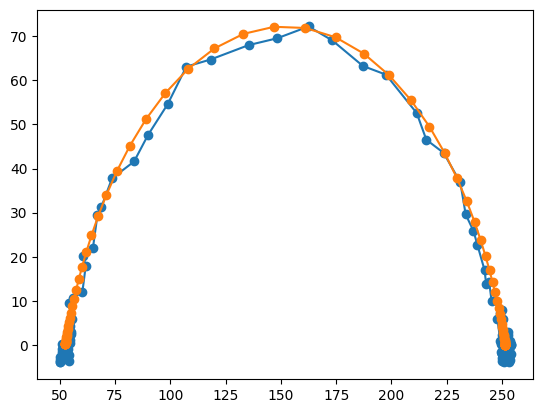

In [ ]:
from scipy.optimize import least_squares

def residual(params, freq, Z_exp):
    Z_model = Randles_CPE(params)
    return Z_exp - Z_model.impedance(freq)

Z_exp = impedance_exp
result = least_squares(residual, [50, 200, 1e-6, 0.8], args=(omega, Z_exp))
print(result.x)
print(result.cost)

plt.plot(Z_exp[::2], -Z_exp[1::2], "-o")
plt.plot(
    Randles_CPE(result.x).realImpedance(omega),
    -Randles_CPE(result.x).imagImpedance(omega),
    "-o"
    )
plt.show()